<a href="https://colab.research.google.com/github/davidwhogg/FlexibleLinearModels/blob/main/ipynb/experiments_with_reweighting_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Re-weighting features and the connection to GPs

## authors
- **David W Hogg** *(NYU) (MPIA) (Flatiron)*
- **Soledad Villar** *(JHU)*

## license
Copyright 2020 the authors. All rights reserved (for now).

## to-do list
- Submit the document at https://www.overleaf.com/project/5fa988f4d1e4cade0e8438d9 to *EPJ Data Science*.
- Reconsider all one-letter variable names.
- Perhaps try an L1 regularization, and a weighted L1? (see paper by Ward).


In [1]:
import numpy as np
import pylab as plt
from scipy.special import gamma
%matplotlib inline
np.random.seed(8675309) # MAGIC to enforce reproducibility
RCOND = 1e-14 # MAGIC input to `np.linalg.lstsq()`

In [2]:
# has to be in its own cell?
plt.rc('figure', figsize=(6.0, 3.6), dpi=150, autolayout=True)
# plt.rc('text', usetex=True)

In [3]:
def truefunction(ts):
  """
  This function produces the TRUTH, which does not lie in the basis spanned by
  the Fourier modes.
  """
  return 1.0 * np.sin(11. * ts) / ts + 1.0 * ts * np.cos(37 * ts) + 0.5 * np.sin(400 * ts)

In [4]:
n = 23
T = 1.5 # range
deltaomega = 0.5 * np.pi / T # frequency spacing for Fourier series

# generate like a Ward
# ts = T * np.arange(0.5 / n, 1., 1. / n)

# generate like a Hogg (harder problem!)
# ts = np.sort(T * np.random.uniform(size=n))

# generate intermediate between Hogg and Ward
ts = (T * (np.arange(0.5 / n, 1., 1. / n)
      + (0.75 / n) * (np.random.uniform(size=n) - 0.5))) # magic 0.75

Y = truefunction(ts)

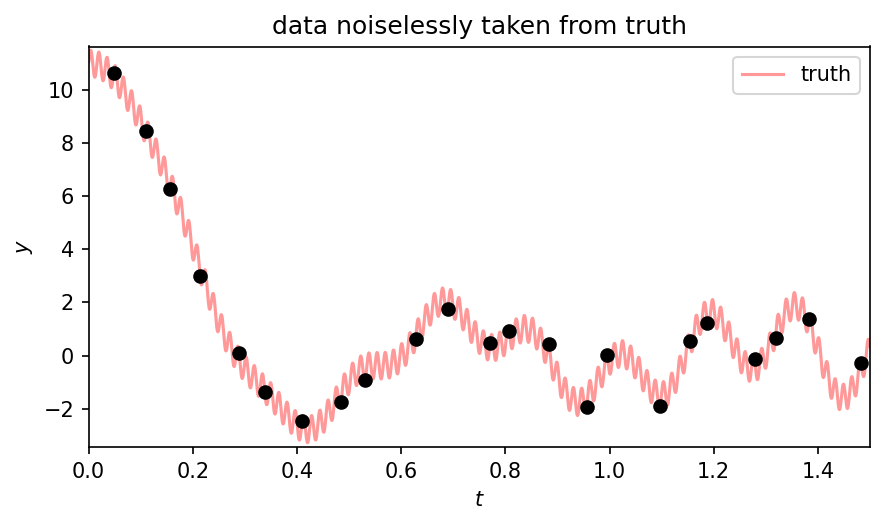

In [5]:
nnn = 2048
plott = np.arange(0.5 * T / nnn, T, T / nnn)
plt.plot(ts, Y, "ko", zorder=100)
plt.plot(plott, truefunction(plott), "r-", alpha=0.4, label="truth")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.title("data noiselessly taken from truth")
plt.legend()

In [6]:
def fourier_design_matrix(ts, deltaomega, p):
  """
  Make the design matrix (feature embedding) for the fit.

  ## Notes:
  - Makes sin() before cos() to be consistent with the document.
  """
  omegas = np.zeros(p) + np.nan
  design_matrix = np.zeros((len(np.atleast_1d(ts)), p))
  omegas[0] = 0.
  design_matrix[:, 0] = 1.
  for j in range(1, p):
    omega = np.floor((j + 1.0001) / 2.) * deltaomega
    omegas[j] = omega
    if j % 2 == 1:
      design_matrix[:, j] = np.sin(omega * ts)
    else:
      design_matrix[:, j] = np.cos(omega * ts)
  return design_matrix, omegas

In [7]:
def train_feature_weighted_ols(xs, ys, ws=None):
  n, p = xs.shape
  if ws is None:
    ws = np.ones(p)
  return np.linalg.lstsq(xs * ws[None, :], ys, rcond=RCOND)[0].T * ws

def train_wls(xs, ys, ws=None):
  n, p = xs.shape
  if ws is None:
    ws = np.ones(n)
  return np.linalg.lstsq(ws[:, None] * xs , ws * ys, rcond=RCOND)[0].T

def train_feature_weighted_wls(xs, ys, Lambdadiag=None, Cdiag=None):
  n, p = xs.shape
  if Lambdadiag is None:
    Lambdadiag = np.ones(p)
  if Cdiag is None:
    Cdiag = np.ones(n)
  if p < n:
    XTCinv = xs.T / Cdiag
    XTCinvX = XTCinv @ xs
    XTCinvX[np.diag_indices(p)] += Lambdadiag
    return np.linalg.lstsq(XTCinvX, XTCinv @ ys, rcond=RCOND)[0]
  LinvXT = (xs / Lambdadiag).T
  XLinvXT = xs @ LinvXT
  XLinvXT[np.diag_indices(n)] += Cdiag
  return LinvXT @ np.linalg.lstsq(XLinvXT, ys, rcond=RCOND)[0]

def train_ridge(xs, ys, lamb):
  n, p = xs.shape
  return np.linalg.solve(xs.T @ xs + lamb * np.eye(p), xs.T @ ys)

def weight_function_exp2(omegas, width):
  """
  This function is chosen because we know the F.T. of its square.

  ## comments:
  - The "width" is in spatial separation, so it is really an inverse width here
    in Fourier space.

  ## bugs:
  - Must be synchronized with `kernel_function()`.
  """
  return np.sqrt(np.exp(-0.5 * omegas ** 2 * width ** 2))

def kernel_function_exp2(deltat, width, deltaomega=None):
  """
  ## inputs:
  - width -- real-space units.

  ## optional inputs:
  - deltaomega -- if set, make the kernel strictly periodic with this angular
                  frequency

  ## bugs:
  - Must be synchronized with `weight_function()`.
  - Pesky `2. * T` out front; what's up with that? It is related to the `0.5`
    in `fourier_design_matrix()`.
  """
  denominator = np.sqrt(2. * np.pi * width ** 2)
  numerator = 2. * T * np.exp(-0.5 * deltat ** 2 / width ** 2)
  if deltaomega is not None:
    for dt in np.array([-2. * np.pi / deltaomega, 2. * np.pi / deltaomega]):
      numerator += 2. * np.exp(-0.5 * (deltat + dt) ** 2 / width ** 2)
  return numerator / denominator

def weight_function_exp(omegas, width):
  """
  This function is chosen because we know the F.T. of its square.

  ## comments:
  - The "width" is in spatial separation, so it is really an inverse width here
    in Fourier space.

  ## bugs:
  - Must be synchronized with `kernel_function()`.
  """
  return np.sqrt(np.sqrt(2. / np.pi) / (1. / width + width * omegas ** 2))

def kernel_function_exp(deltat, width):
  """
  ## inputs:
  - width -- real-space units.

  ## optional inputs:
  - deltaomega -- if set, make the kernel strictly periodic with this angular
                  frequency

  ## bugs:
  - Must be synchronized with `weight_function()`.
  - Pesky `2. * T` out front; what's up with that? It is related to the `0.5`
    in `fourier_design_matrix()`.
  """
  return np.exp(-np.abs(deltat) / width)

def weight_function_mat32(omegas, width):
  """
  This function is chosen because we know the F.T. of its square.

  ## comments:
  - The "width" is in spatial separation, so it is really an inverse width here
    in Fourier space.

  ## bugs:
  - Must be synchronized with `kernel_function()`.
  """
  return 1. / (width ** 2 * omegas ** 2 + 1.)

def kernel_function_mat32(deltat, width):
  """
  ## inputs:
  - width -- real-space units.

  ## optional inputs:
  - deltaomega -- if set, make the kernel strictly periodic with this angular
                  frequency

  ## bugs:
  - Must be synchronized with `weight_function()`.
  - Pesky `2. * T` out front; what's up with that? It is related to the `0.5`
    in `fourier_design_matrix()`.
  """
  abstoverw = np.abs(deltat) / width
  return (np.pi / 8.) * (1. + abstoverw) * np.exp(-abstoverw)

weight_function = weight_function_mat32
kernel_function = kernel_function_mat32
width = 0.05 # t-space width of the kernel s

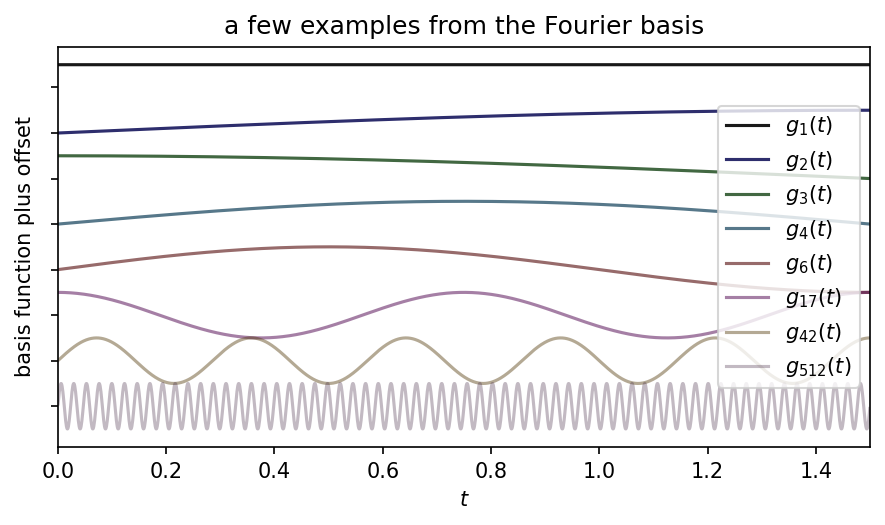

In [8]:
# plot a few basis functions
cs = [(0.0, 0.0, 0.0),
      (0.0, 0.0, 0.3),
      (0.0, 0.2, 0.0),
      (0.0, 0.2, 0.3),
      (0.3, 0.0, 0.0),
      (0.3, 0.0, 0.3),
      (0.3, 0.2, 0.0),
      (0.3, 0.2, 0.3),
      #(0.0, 0.0, 0.6),
      (0.0, 0.0, 0.9),
      (0.0, 0.2, 0.6),
      (0.0, 0.2, 0.9),
      (0.3, 0.0, 0.6),
      (0.3, 0.0, 0.9),
      (0.3, 0.2, 0.6),
      (0.3, 0.2, 0.9)]
js = [0, 1, 2, 3, 5, 16, 41, 511]
plotX, _ = fourier_design_matrix(plott, deltaomega, np.max(js) + 2)
for i, j in enumerate(js):
  plt.plot(plott, plotX[:,j] + 2 * len(js) - 2 * i,
           ls="-", color=cs[i], alpha=0.9 - 0.08 * i,
           label=r"$g_{{{}}}(t)$".format(j + 1))
plt.xlim(0., T)
plt.xlabel(r"$t$")
plt.ylabel("basis function plus offset")
plt.title("a few examples from the Fourier basis")
plt.gca().set_yticklabels([])
plt.legend(loc="right")
plt.savefig("fourier.pdf")

In [9]:
# get ready to plot different p values
pps = [3, 7, 21, 30, 73, 2049]
betas = []
for p in pps:
  X, omegas = fourier_design_matrix(ts, deltaomega, p)
  betas.append(train_feature_weighted_ols(X, Y))

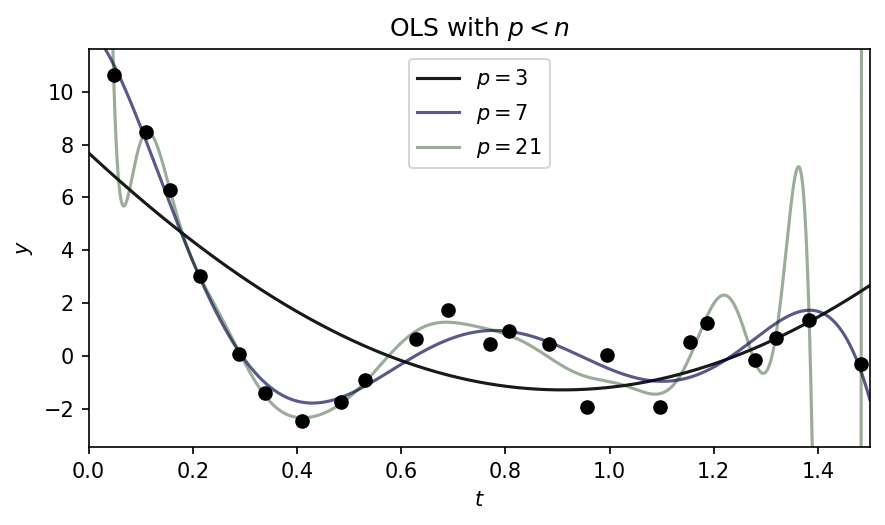

In [10]:
plt.plot(ts, Y, "ko", zorder=100)
for i, (beta, p) in enumerate(zip(betas, pps)):
  if p < n:
    plotX, _ = fourier_design_matrix(plott, deltaomega, p)
    plt.plot(plott, plotX @ beta, ls="-", color=cs[i], alpha=0.9 - 0.25 * i, label="$p = {}$".format(p))
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title(r"OLS with $p < n$")
plt.legend()
plt.savefig("OLS-under.pdf")

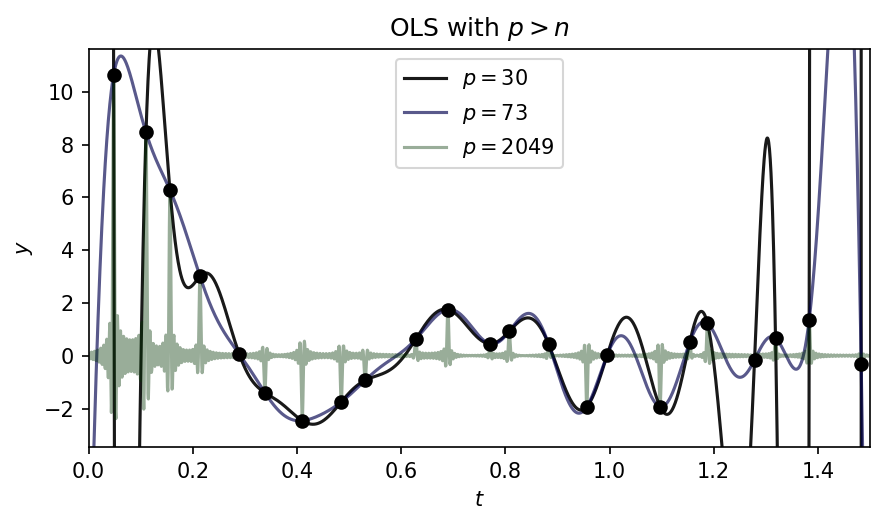

In [11]:
plt.plot(ts, Y, "ko", zorder=100)
j = 0
for i, (beta, p) in enumerate(zip(betas, pps)):
  if p > n:
    plotX, _ = fourier_design_matrix(plott, deltaomega, p)
    plt.plot(plott, plotX @ beta, ls="-", color=cs[j], alpha=0.9 - 0.25 * j, label="$p = {}$".format(p))
    j += 1
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title(r"OLS with $p > n$")
plt.legend()
plt.savefig("OLS-over.pdf")

In [12]:
# get ready to plot OLS v WLS
p = 3
X, omegas = fourier_design_matrix(ts, deltaomega, p)
print(ts.shape, X.shape, Y.shape, omegas.shape)
beta_default = train_feature_weighted_ols(X, Y)
errs = 5. / (np.arange(n) + 2.) + 0.25
errs[0:2] *= 6.
Cdiag = errs ** 2
beta_underp = train_wls(X, Y, 1. / Cdiag)

(23,) (23, 3) (23,) (3,)


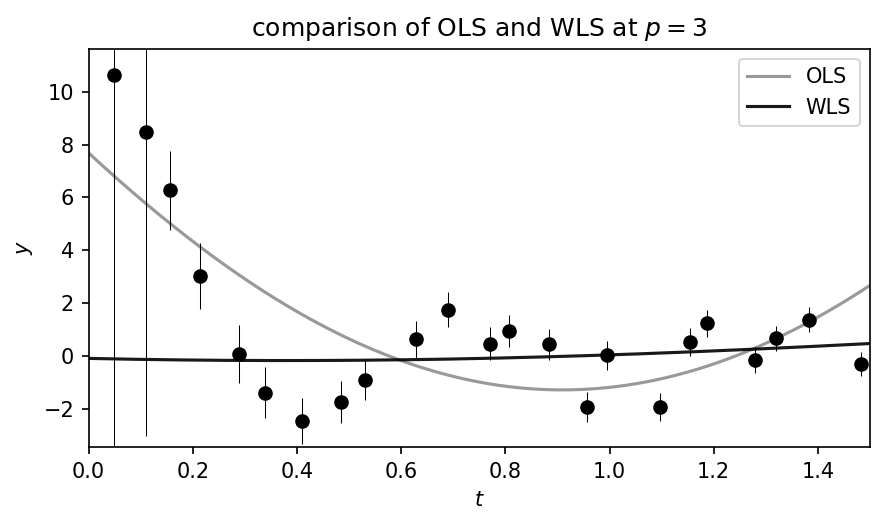

In [13]:
plotX, _ = fourier_design_matrix(plott, deltaomega, p)
plt.errorbar(ts, Y, yerr=np.sqrt(Cdiag), color='k', fmt="o", lw=0.5)
plt.plot(plott, plotX @ beta_default, "k-", alpha=0.4, label="OLS")
plt.plot(plott, plotX @ beta_underp, "k-", alpha=0.9, label="WLS")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title("comparison of OLS and WLS at $p = {}$".format(p))
plt.legend()
plt.savefig("WLS.pdf")

In [14]:
p = 21
X, omegas = fourier_design_matrix(ts, deltaomega, p)
print(ts.shape, X.shape, Y.shape, omegas.shape)
beta_default = train_feature_weighted_ols(X, Y)
lamb = 0.1
beta_ridge = train_ridge(X, Y, 0.1)

(23,) (23, 21) (23,) (21,)


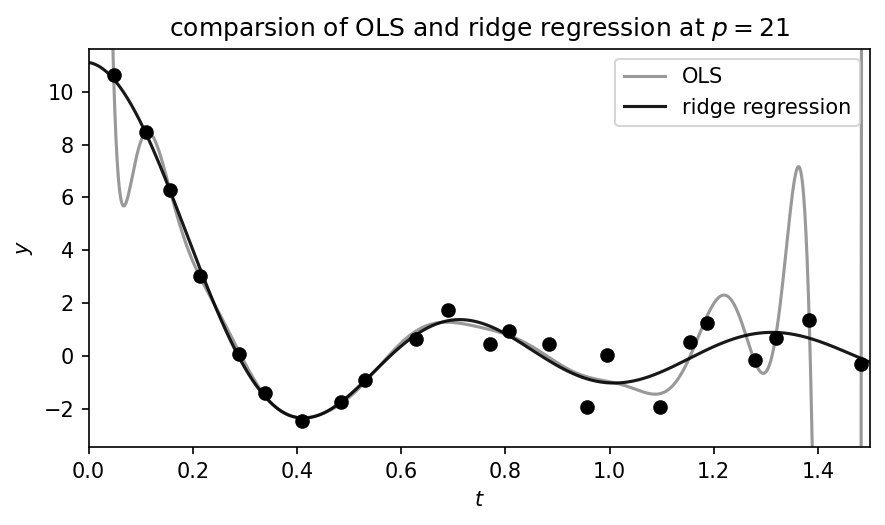

In [15]:
plotX, _ = fourier_design_matrix(plott, deltaomega, p)
plt.plot(ts, Y, "ko", zorder=100)
plt.plot(plott, plotX @ beta_default, "k-", alpha=0.4, label="OLS")
plt.plot(plott, plotX @ beta_ridge, "k-", alpha=0.9, label="ridge regression")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title("comparsion of OLS and ridge regression at $p = {}$".format(p))
plt.legend()
plt.savefig("ridge.pdf")

In [61]:
p = 1024
X, omegas = fourier_design_matrix(ts, deltaomega, p)
print(ts.shape, X.shape, Y.shape, omegas.shape)
beta_default = train_feature_weighted_ols(X, Y)
beta_smooth = train_feature_weighted_ols(X, Y, weight_function(omegas, width))
beta_smooth2 = train_feature_weighted_ols(X, Y, weight_function(omegas, width) ** 0.25)
Lambdadiag = 1. / (0.07 * weight_function(omegas, width) ** 2) # MAGIC 0.07
beta_CLambda = train_feature_weighted_wls(X, Y, Lambdadiag, Cdiag)

(23,) (23, 1024) (23,) (1024,)


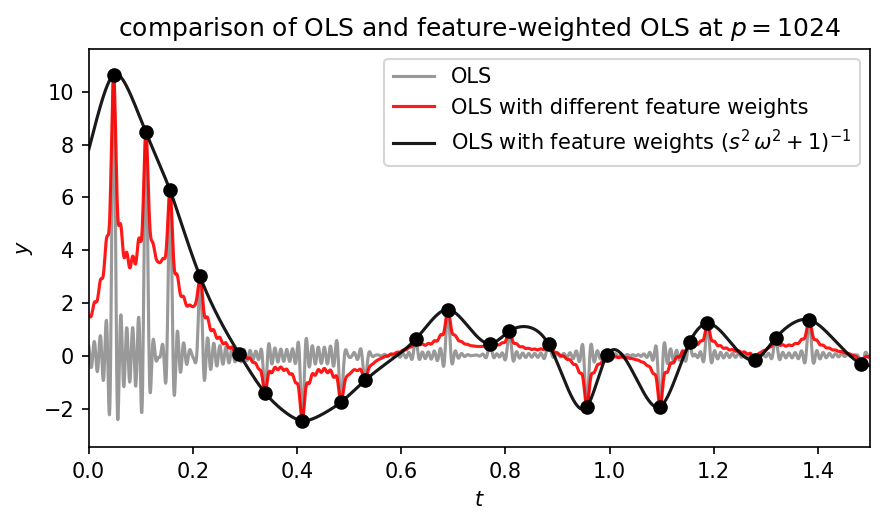

In [62]:
plotX, _ = fourier_design_matrix(plott, deltaomega, p)
plt.plot(ts, Y, "ko", zorder=100)
plt.plot(plott, plotX @ beta_default, "k-", alpha=0.4, label="OLS")
plt.plot(plott, plotX @ beta_smooth2, "r-", alpha=0.9, label=r"OLS with different feature weights")
plt.plot(plott, plotX @ beta_smooth, "k-", alpha=0.9, label=r"OLS with feature weights $(s^2\,\omega^2 + 1)^{-1}$")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title("comparison of OLS and feature-weighted OLS at $p = {}$".format(p))
plt.legend()
plt.savefig("weighted-OLS.pdf")

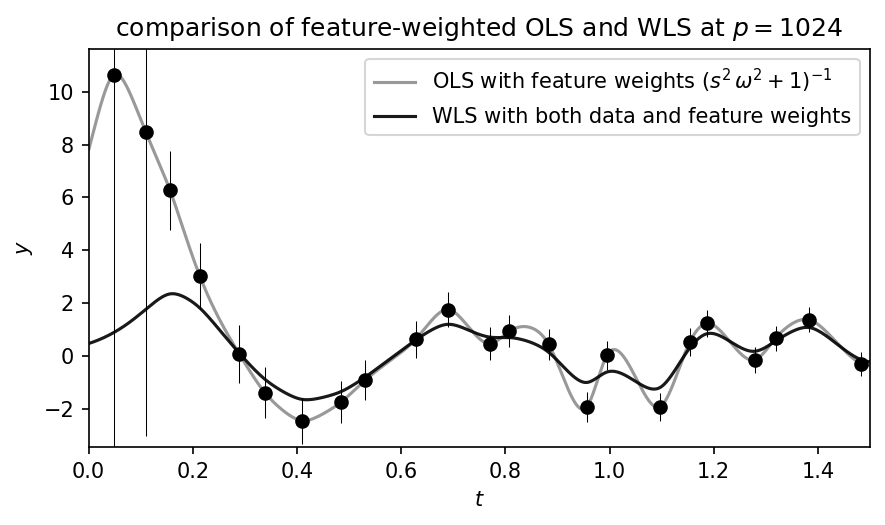

In [18]:
plotX, _ = fourier_design_matrix(plott, deltaomega, p)
plt.errorbar(ts, Y, yerr=np.sqrt(Cdiag), color='k', fmt="o", lw=0.5)
plt.plot(plott, plotX @ beta_smooth, "k-", alpha=0.4, label=r"OLS with feature weights $(s^2\,\omega^2 + 1)^{-1}$")
plt.plot(plott, plotX @ beta_CLambda, "k-", alpha=0.9, label="WLS with both data and feature weights")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.title("comparison of feature-weighted OLS and WLS at $p = {}$".format(p))
plt.legend()
plt.savefig("weighted-WLS.pdf")

In [19]:
# set up for GP execution
deltats = ts[:, None] - ts[None, :]
kernel_matrix = kernel_function(deltats, width)
plotdeltas = plott[:, None] - ts[None, :]
rectangular_kernel = kernel_function(plotdeltas, width)
print(rectangular_kernel.shape, kernel_matrix.shape, np.linalg.cond(kernel_matrix))
# execute GP
gp_y = rectangular_kernel @ np.linalg.lstsq(kernel_matrix, Y, rcond=RCOND)[0]
gp_mse = np.mean((gp_y - truefunction(plott)) ** 2)

(2048, 23) (23, 23) 37.543089455414524


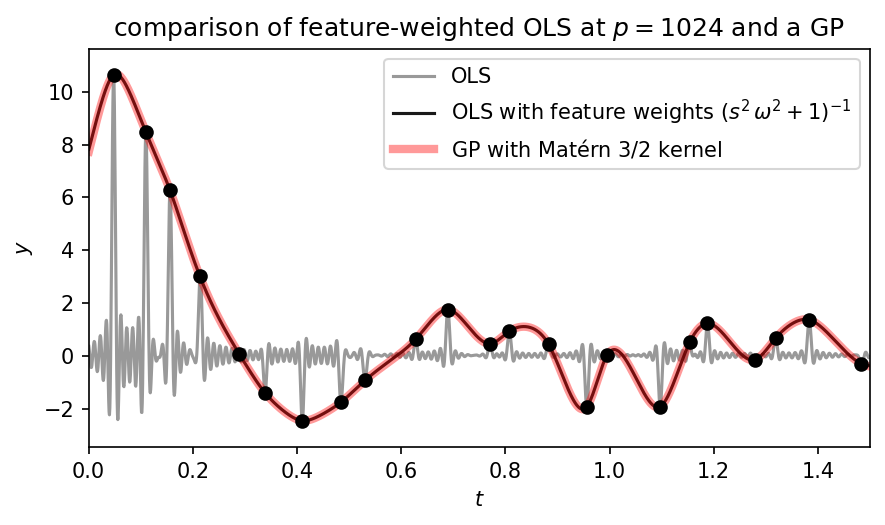

In [20]:
plt.plot(ts, Y, "ko", zorder=100)
plt.plot(plott, plotX @ beta_default, "k-", alpha=0.4, label="OLS")
plt.plot(plott, plotX @ beta_smooth, "k-", alpha=0.9, label=r"OLS with feature weights $(s^2\,\omega^2 + 1)^{-1}$")
plt.plot(plott, gp_y, "r-", lw=4, alpha=0.4, label=r"GP with Matérn $3/2$ kernel")
plt.ylabel("$y$")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.title("comparison of feature-weighted OLS at $p = {}$ and a GP".format(p))
plt.legend()
plt.savefig("GP.pdf")

In [21]:
# make things for a cross-validation demo figure
p = 15
X, omegas = fourier_design_matrix(ts, deltaomega, p)
beta = train_feature_weighted_ols(X, Y, weight_function(omegas, width))
betas = np.zeros((n, p))
for i in range(n):
  ts_loo, Y_loo = np.delete(ts, i), np.delete(Y, i)
  X, omegas= fourier_design_matrix(ts_loo, deltaomega, p)
  betas[i] = train_feature_weighted_ols(X, Y_loo, weight_function(omegas, width))

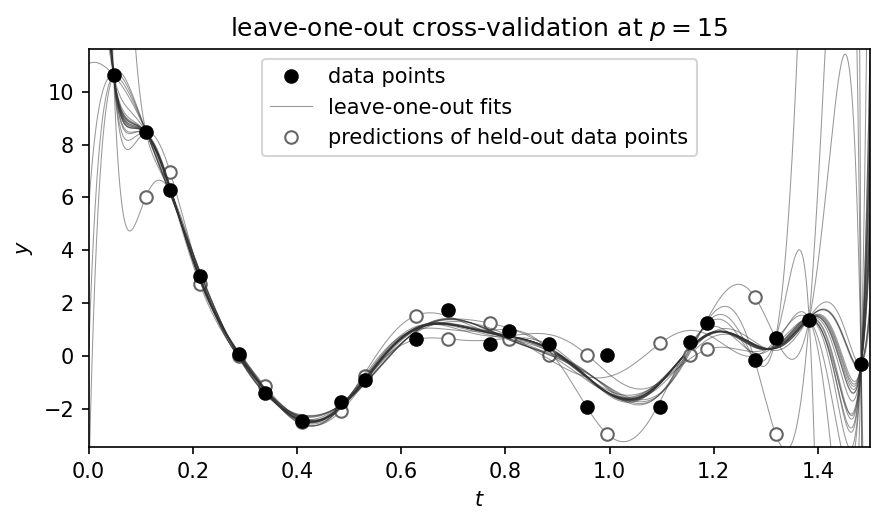

In [22]:
plotX, _ = fourier_design_matrix(plott, deltaomega, p)
plt.plot(ts, Y, "ko", zorder=100, label="data points")
# plt.plot(plott, plotX @ beta, "k-", alpha=0.9, label="feature-weighted OLS using all points")
for i in range(n):
  label, label2 = None, None
  if i == 0:
    label = "leave-one-out fits"
    label2 = "predictions of held-out data points"
  plt.plot(plott, plotX @ betas[i], ls="-", color=(0.2, 0.2, 0.2), alpha=0.5, lw=0.5, label=label)
  oneX, _ = fourier_design_matrix(ts[i], deltaomega, p)
  plt.plot(ts[i], oneX @ betas[i], "ko", mfc="w", mec=(0.4, 0.4, 0.4), label=label2)
plt.ylabel("$y$")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.title("leave-one-out cross-validation at $p = {}$".format(p))
plt.legend()
plt.savefig("LOO.pdf")

In [23]:
# make things for a jackknife figure
p = 5
X, omegas = fourier_design_matrix(ts, deltaomega, p)
beta = train_feature_weighted_ols(X, Y, weight_function(omegas, width))
betas = np.zeros((n, p))
for i in range(n):
  ts_loo, Y_loo = np.delete(ts, i), np.delete(Y, i)
  X, omegas= fourier_design_matrix(ts_loo, deltaomega, p)
  betas[i] = train_feature_weighted_ols(X, Y_loo, weight_function(omegas, width))

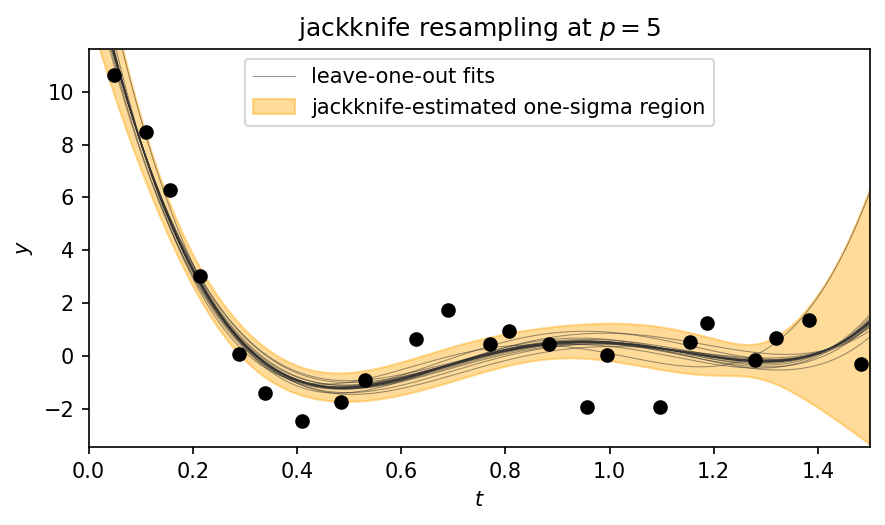

In [24]:
plotX, _ = fourier_design_matrix(plott, deltaomega, p)
meanyhat = np.mean(plotX @ betas.T, axis=1)
varyhat = ((n - 1) / n) * np.sum((plotX @ betas.T - meanyhat[:, None]) ** 2, axis=1)
plt.plot(ts, Y, "ko", zorder=100)
for i in range(n):
  label = None
  if i == 0:
    label = "leave-one-out fits"
  plt.plot(plott, plotX @ betas[i], ls="-", color=(0.2, 0.2, 0.2), alpha=0.5, lw=0.5, label=label, zorder=50)
plt.fill_between(plott, meanyhat + np.sqrt(varyhat),
                 meanyhat - np.sqrt(varyhat), color="orange", alpha=0.4,
                 label="jackknife-estimated one-sigma region")
plt.ylabel("$y$")
plt.xlim(0., T)
plt.ylim(np.min(Y)-1., np.max(Y)+1.)
plt.xlabel("$t$")
plt.title("jackknife resampling at $p = {}$".format(p))
plt.legend(loc="upper center")
plt.savefig("uncertainty.pdf")

In [25]:
# list of p values to try
ps = np.unique(np.round(np.exp(np.arange(np.log(1.), np.log(257.), 0.20 * np.log(2.))).astype(int)))
print(ps)

[  1   2   3   4   5   6   7   9  10  12  13  15  18  21  24  27  31  36
  42  48  55  63  73  84  97 111 127 147 168 194 222 255]


In [38]:
# now do all LOO CV tests for p
n = len(ts)
loo_errors = np.zeros((len(ps), n)) + np.nan
loo_errors_gp = np.zeros(n) + np.nan
loo_errors_null = np.zeros(n) + np.nan
loo_errors_ridge = np.zeros((len(ps), n)) + np.nan
conds = np.zeros(len(ps)) + np.nan
for j, pp in enumerate(ps):
  if pp == 1:
    conds[j] = 1
  else:
    X, omegas = fourier_design_matrix(ts, deltaomega, pp)
    Xw = X * weight_function(omegas, width)[None, :]
    eigs = np.linalg.eigvalsh(Xw @ Xw.T)[::-1]
    minnp = min(n, pp) - 1
    conds[j] = eigs[0] / eigs[minnp]
  for i in range(1, n-1):
    ts_loo, Y_loo = np.delete(ts, i), np.delete(Y, i)
    X, omegas= fourier_design_matrix(ts_loo, deltaomega, pp)
    beta = train_feature_weighted_ols(X, Y_loo, weight_function(omegas, width))
    xi, _ = fourier_design_matrix(ts[i], deltaomega, pp)
    loo_errors[j, i] = xi @ beta - Y[i]
    beta_ridge = train_ridge(X, Y_loo, lamb)
    loo_errors_ridge[j, i] = xi @ beta_ridge - Y[i]
    if j == 0:
      loo_errors_null[i] = np.mean(Y_loo) - Y[i]
      deltats = ts_loo[:, None] - ts_loo[None, :]
      kernel_matrix = kernel_function(deltats, width)
      rectangular_kernel = kernel_function(ts_loo - ts[i], width)
      gp_y = rectangular_kernel @ np.linalg.lstsq(kernel_matrix, Y_loo, rcond=RCOND)[0]
      loo_errors_gp[i] = gp_y - Y[i]

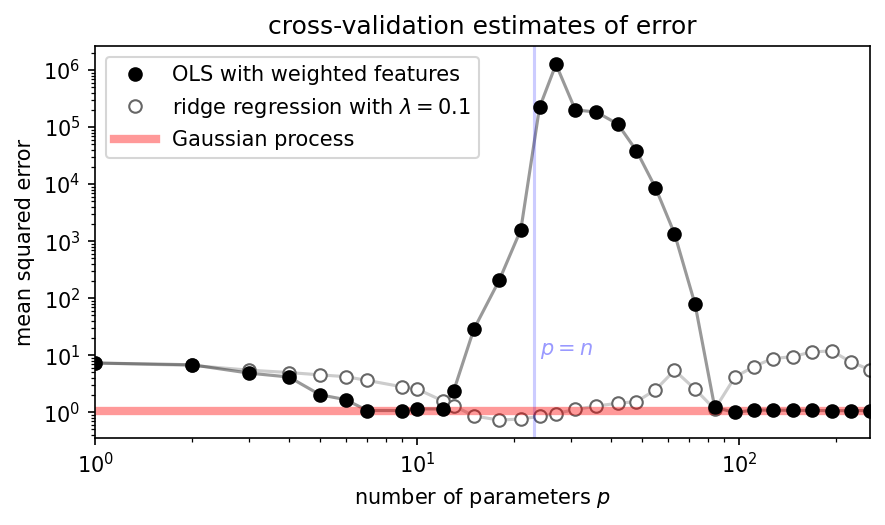

In [39]:
mses = np.nanmean(loo_errors ** 2, axis=1)
ridge = np.nanmean(loo_errors_ridge ** 2, axis=1)
gp = np.nanmean(loo_errors_gp ** 2)
null = np.nanmean(loo_errors_null ** 2)
plt.plot(ps, mses, "ko", label="OLS with weighted features", zorder=100)
plt.plot(ps, mses, "k-", alpha=0.4)
plt.plot(ps, ridge, "k-", alpha=0.2)
plt.plot(ps, ridge, "ko", mfc="w", mec=(0.4, 0.4, 0.4), label=r"ridge regression with $\lambda = 0.1$")
plt.axvline(n, color="b", alpha=0.2)
yl = 10. * np.min(mses)
plt.text(n, yl, " $p = n$", color="b", alpha=0.4)
# plt.axhline(null, color="k", alpha=0.2, label = "null (mean) prediction")
plt.axhline(gp, color="r", lw=4, alpha=0.4, label = "Gaussian process")
plt.xlim(np.min(ps), np.max(ps))
plt.loglog()
plt.xlabel("number of parameters $p$")
plt.ylabel("mean squared error")
plt.legend()
plt.title("cross-validation estimates of error")
plt.savefig("cross-validation.pdf")
ax = plt.gca()

[]

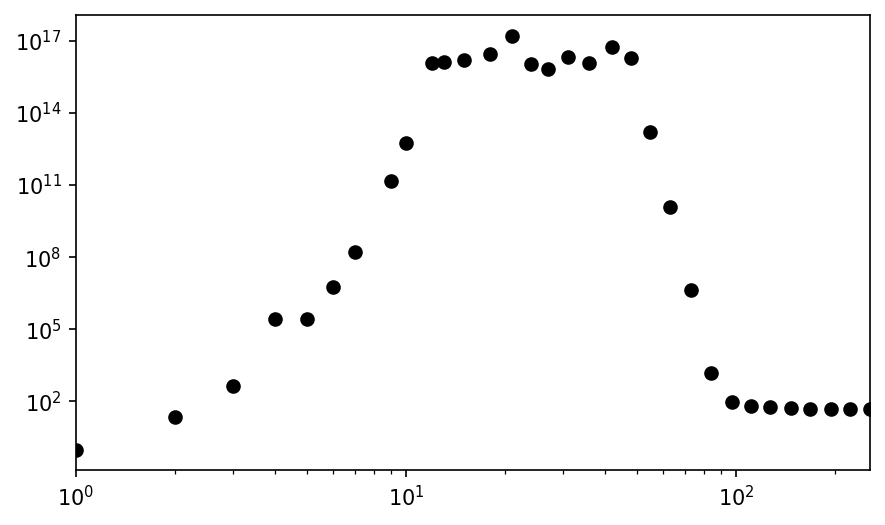

In [40]:
plt.plot(ps, np.abs(conds), "ko")
plt.xlim(np.min(ps), np.max(ps))
plt.loglog()

In [50]:
# now do all LOO CV tests for s instead
esses = np.exp(np.arange(np.log(3.e-4), np.log(3.1e1), 0.25 * np.log(10.)))
n = len(ts)
p = 128
loo_errors_s = np.zeros((len(esses), n)) + np.nan
for j, ss in enumerate(esses):
  for i in range(1, n-1):
    ts_loo, Y_loo = np.delete(ts, i), np.delete(Y, i)
    X, omegas= fourier_design_matrix(ts_loo, deltaomega, p)
    beta = train_feature_weighted_ols(X, Y_loo, weight_function(omegas, ss)) # is this line correct?
    xi, _ = fourier_design_matrix(ts[i], deltaomega, p)
    loo_errors_s[j, i] = xi @ beta - Y[i]

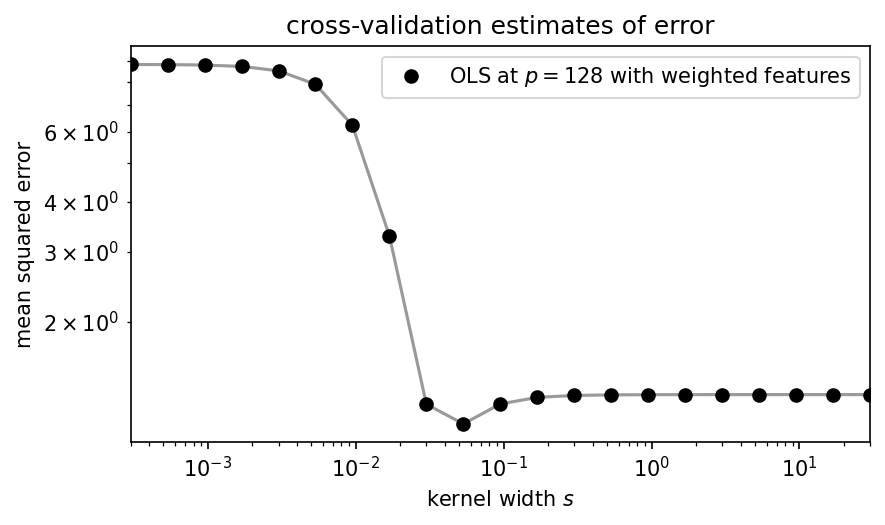

In [51]:
mses = np.nanmean(loo_errors_s ** 2, axis=1)
plt.plot(esses, mses, "ko", label="OLS at $p={}$ with weighted features".format(p), zorder=100)
plt.plot(esses, mses, "k-", alpha=0.4)
yl = 10. * np.min(mses)
plt.xlim(np.min(esses), np.max(esses))
plt.loglog()
plt.xlabel("kernel width $s$")
plt.ylabel("mean squared error")
plt.legend()
plt.title("cross-validation estimates of error")
plt.savefig("cross-validation_s.pdf")

In [57]:
# now do all LOO CV tests for exponent instead
expos = np.arange(0., 5.01, 0.2)
n = len(ts)
p = 1024
loo_errors_e = np.zeros((len(expos), n)) + np.nan
for j, ee in enumerate(expos):
  for i in range(1, n-1):
    ts_loo, Y_loo = np.delete(ts, i), np.delete(Y, i)
    X, omegas= fourier_design_matrix(ts_loo, deltaomega, p)
    beta = train_feature_weighted_ols(X, Y_loo, weight_function(omegas, width) ** ee)
    xi, _ = fourier_design_matrix(ts[i], deltaomega, p)
    loo_errors_e[j, i] = xi @ beta - Y[i]

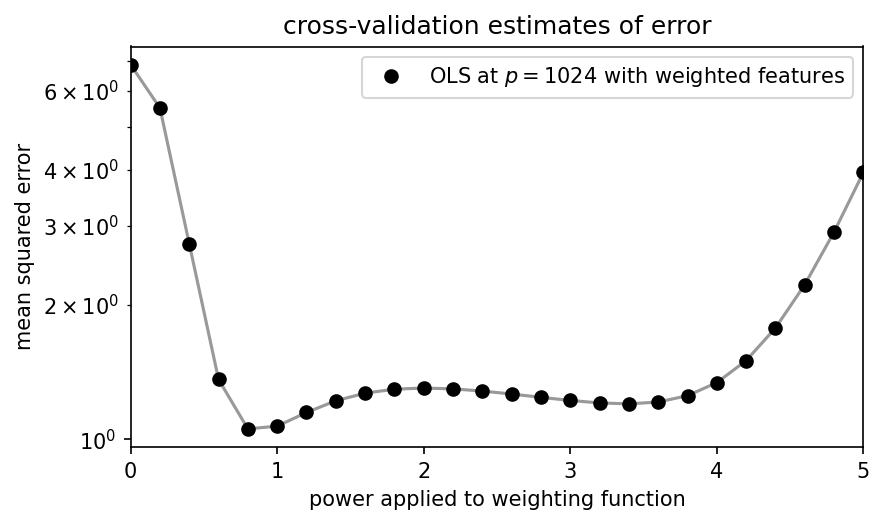

In [58]:
mses = np.nanmean(loo_errors_e ** 2, axis=1)
plt.plot(expos, mses, "ko", label="OLS at $p={}$ with weighted features".format(p), zorder=100)
plt.plot(expos, mses, "k-", alpha=0.4)
yl = 10. * np.min(mses)
plt.xlim(np.min(expos), np.max(expos))
plt.semilogy()
plt.xlabel("power applied to weighting function")
plt.ylabel("mean squared error")
plt.legend()
plt.title("cross-validation estimates of error")
plt.savefig("cross-validation_e.pdf")